---
title       : "Semiparametric Inference with Neural Networks" 
subtitle    : ""
author      : Paul Schrimpf
date        : `j using Dates; print(Dates.today())`
bibliography: "../ml.bib"
options:
      out_width : 100%
      wrap : true
      fig_width : 800
      fig_height : 800
      dpi : 192
---

[![](https://i.creativecommons.org/l/by-sa/4.0/88x31.png)](http://creativecommons.org/licenses/by-sa/4.0/)

This work is licensed under a [Creative Commons Attribution-ShareAlike
4.0 International
License](http://creativecommons.org/licenses/by-sa/4.0/) 


### About this document 

This document was created using Weave.jl. The code is available in
[on github](https://github.com/schrimpf/NeuralNetworkEconomics.jl). The same
document generates both static webpages and associated [jupyter
notebook](nn-semiparametric.ipynb). 

$$
\def\indep{\perp\!\!\!\perp}
\def\Er{\mathrm{E}}
\def\R{\mathbb{R}}
\def\En{{\mathbb{E}_n}}
\def\Pr{\mathrm{P}}
\newcommand{\norm}[1]{\left\Vert {#1} \right\Vert}
\newcommand{\abs}[1]{\left\vert {#1} \right\vert}
\DeclareMathOperator*{\argmax}{arg\,max}
\DeclareMathOperator*{\argmin}{arg\,min}
$$

In [1]:
markdown = try
  "md" in keys(WEAVE_ARGS) && WEAVE_ARGS["md"]
catch
  false
end

if !("DISPLAY" ∈ keys(ENV))
  # Make gr and pyplot backends for Plots work without a DISPLAY
  ENV["GKSwstype"]="nul"
  ENV["MPLBACKEND"]="Agg"
end
# Make gr backend work with λ and other unicode
ENV["GKS_ENCODING"] = "utf-8"

using NeuralNetworkEconomics
docdir = joinpath(dirname(Base.pathof(NeuralNetworkEconomics)), "..","docs")

using Pkg
Pkg.activate(docdir)
Pkg.instantiate()

Activating environment at `~/.julia/dev/NeuralNetworkEconomics/docs/Project.toml`
  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`


# Introduction 

We have now covered a variety of neural network architectures and seen
examples of how they are used for classic machine learning tasks. How
can neural networks be incorporated into typical economic research?

There are two important differences between empirical economics and
the digit classification and text generation examples we looked at:

1. Economic data has a lot more inherent uncertainty. In both images
   and text, we know there is a nearly perfect model (our eyes and
   brain). In economics, perfect prediction is almost never
   possible. For example, if we could predict stock prices even
   slightly more accurately than a random walk, then we could be
   billionares. 
   
2. In part related to 1, economists care about statistical inference
   and quantifying uncertainty. 

Both of these factors are going to make concerns about overfitting and
model complexity more important. 

This note will focus on one way to use neural networks in estimable
economic models that allows inference. Inference directly on the
nonparametric function fitted by a neural network is a very difficult
problem. There are practical methods for Bayesian variational
inference (see @graves2011 or @miao2016), but frequentist inference is
largely an open problem. 

However, what is possible is semiparametric inference. Semiparametric
inference refers to when we have a finite dimensional parameter of
interest that depends on some infinite dimensional parameter. Examples
include average (or quantiles or other summary statistic) marginal
effects, average treatment effects, and many others. 

# Double Debiased Machine Learning

We return to the semiparametric moment condition model of
@chernozhukov2018 and @chernozhukov2017. We previously discussed this
setting in [ml-intro](ml-intro.md) and
[ml-doubledebiased](ml-doubledebiased.md). 

The model consists of

- Parameter of interest $\theta \in \R^{d_\theta}$

- Nuisance parameter $\eta \in T$ (where $T$ is typically some space
  of functions)

- Moment conditions
  $$
  \Er[\psi(W;\theta_0,\eta_0) ] = 0 \in \R^{d_\theta}
  $$
  where $\psi$ known

See [ml-intro](ml-intro.md) and
[ml-doubledebiased](ml-doubledebiased.md) for examples.

The estimation procedure will proceed in two steps:

1. Estimate $\hat{\eta}$ from a neural network

2. Estimate $\hat{\theta}$ from the empirical moment condition with
   $\hat{eta}$ plugged in:
   $$
   \En[\psi(W;\hat{\theta},\hat{eta}) ] \approx 0 
   $$

@chernozhukov2018 provide high level assumptions on $\hat{\eta}$ and
the model that ensure $\hat{\theta}$ is $\sqrt{n}$ asymptotically
normal.[^1] The key needed assumptions are:

[^1]: @chernozhukov2018 also give low level conditions on lasso
    estimates of $\hat{eta}$ that meet the high level assumptions.

1. Linearizeable score
$$
\psi(w;\theta,\eta) = \psi^a(w;\eta) \theta + \psi^b(w;\eta) + o_p(?)
$$
2. (Near) Neyman orthogonality:
$$
\lambda_n := \sup_{\eta \in \mathcal{T}_n} \norm{\partial \eta
\Er\left[\psi(W;\theta_0,\eta_0)[\eta-\eta_0] \right] } \leq \delta_n
n^{-1/2}
$$
3. Fast enough convergence of $\hat{eta}$: for $\delta_n \to 0$ and
$\Delta_n \to 0$, we have 
$\Pr(\hat{\eta}_k \in \mathcal{T}_n) \geq 1-\Delta_n$ and
$$
\begin{align*}
r_n := & \sup_{\eta \in \mathcal{T}_n} \norm{ \Er[\psi^a(W;\eta)] -
\Er[\psi^a(W;\eta_0)]} \leq \delta_n \\
r_n' := & \sup_{\eta \in \mathcal{T}_n} \Er\left[ \norm{ \psi(W;\theta_0,\eta) -
    \psi(W;\theta_0,\eta_0)}^2 \right]^{1/2} \leq \delta_n \\
\lambda_n' := & \sup_{r \in (0,1), \eta \in \mathcal{T}_n} \norm{
\partial_r^2 \Er\left[\psi(W;\theta_0, \eta_0 + r(\eta - \eta_0))
\right]} \leq \delta_n/\sqrt{n}
\end{align*}
$$

Assumption 1 is stated here mostly to define notation 3. A model where
$\psi$ is not linearizeable would be unusual. 

Assumption 2 must be satisfied by each application. In many models,
the most obvious choice of $\psi$ will not satisfy 2. However, $\psi$
can be orthogonalized to satisfy 2. 

Assumption 3 is about the convergence rate of our estimator for
$\hat{\eta}$. It is written this way because it exactly what is needed
for the proof; it is not intended to be easy to interpret or to
verify. A sufficient, but not necessary condition that implies 3 is
twice differentiability of $\psi$ and 
$\Er[(\hat{\eta}(x) - \eta_0(x))^2]^{1/2}  = o(n^{-1/4})$.

Anyway, @chernozhukov2018 show that under these conditions (and if you
use sample splitting in the empirical moment condition), then 
$$
\sqrt{n} \sigma^{-1} (\hat{\theta} - \theta_0) = \frac{1}{\sqrt{n}}
\sum_{i=1}^n \bar{\psi}(w_i) + O_p(\rho_n) \leadsto N(0,I) 
$$
where 
$$
\rho_n := n^{-1/2} + r_n + r_n' + n^{1/2} (\lambda_n +\lambda_n')
  \lesssim \delta_n
$$
and $\bar{\psi}$ is the influence function, 
$$\bar{\psi}(w) = -\sigma^{-1} J_0^{-1} \psi(w;\theta_0,\eta_0)$$
with
$$
\sigma^2 = J_0^{-1} \Er\left[ \psi(w;\theta_0,\eta_0)
   \psi(w;\theta_0,\eta_0)'\right] (J_0^{-1})'.
$$
This is the same asymptotic distribution as if we plugged in the true
$\eta_0$ instead of our estimated $\hat{\eta}$. 

To apply this result to neural networks we need two things. First, we
need to verify the rate condition (assumption 2). Doing so will
involve conditions on the class of functions being estimated, and how
the complexity (width and depth) of the neural network increases with
sample size. The excellent paper by @farrel2018 provides the needed
results. 

Second, we need to make sure our moment conditions are Neyman
orthogonal. @chernozhukov2018 and @farrel2018 do this for some typical
causal inference models. For other models, analytically transforming
non-orthogonal moments into orthogonal ones is typically possible, but
it can be tedious. 

<!-- We will try to automate this. As we saw in -->
<!-- [GMMInference](https://schrimpf.github.io/GMMInference.jl), Julia's -->
<!-- good support for automatic differentiation will make it relatively -->
<!-- easy to translate econometric theory to executable code.  -->

## Deep Neural Networks for Estimation and Inference

Review results of @farrel2018. 

# Application: Average Impulse Responses

As an application let's consider something like an average impulse
response function. Suppose we have some time series data on $y_t$ and
$x_t$. We want to estimate the average (over the density of $x$) response of
$\Er[y_{t+\tau} | x_t]$ to a change in $x$ of size $\Delta$. That is,
our parameters of interest are
$$
\theta_{0,\tau} = \Er\left[ \Er[y_{t+\tau} | x_{t} + \Delta] -
\Er[y_{t+\tau} | x_{t}] \right]
$$
for $\tau = 0, ..., R$ for some fixed $R$. 

<div class="alert alert-danger">
Note that there are other impulse response like parameters that could
be estimated. For example, we could compute the average over $x_t$ of
the change in future $y$ holding future residuals constant (or setting
future residuals to $0$). In a linear model this would be the same as
the average over residuals response that we estimate. However, in a
nonlinear model, these three things differ. We focus on the average
over residuals response in part because orthogonalization of the
moment condition is more difficult for the later two. 
</div>

Let $h(x_t) = (\Er[y_{t} | x_{t}], ... , \Er[y_{t+R} | x_{t}])$ denote
the conditional expectation functions at different horizons. Then, we
can write a moment condition for $\theta_0$ as:
$$
0 = \Er[ \theta_0 -  \left(h(x_t + \Delta) - h(x_t) \right)].
$$
However, this moment condition is not orthogonal. Its Frechet derivative with
respect to $h$ in direction $v$ is
$$
\partial_h(\Er[ \theta -  \left(h_0(x_t + \Delta) - h(x_t)
\right)] \right) [v] = \Er[-v(x_t + \Delta) + v(x_t)] \neq 0.
$$

We can orthogonalize the moment condition by following the
concentrating out approach described in @chernozhukov2018, or in
[ml-doubledebiased](ml-doubledebiased.md). It would be a good exercise
to work through the steps. Here we will simply state a resulting
orthogonal moment condition. Let $\eta=(h, f_x)$ where $f_x$ is the
density of $x$. Define 
$$
\psi(y,x;\theta, \eta) = \theta - (h(x+\Delta) - h(x)))  - (y -
h(x))\frac{-f_x(x-\Delta)+f_x(x)} {f_x(x)} 
$$

Although somewhat difficult to derive, it is easy to verify that
$\Er \psi$ is orthogonal. 
$$
\begin{align*}
\partial_h \Er[ \psi(y_t,x_t;\theta_0, \eta_0) ] \right) [v] = &
\Er[-v(x_t + \Delta) + v(x_t) + v(x_t +\Delta)  - v(x_t)] = 0 \\
\partial_{f_x} \Er[ \psi(y_t,x_t;\theta_0, \eta_0) ] \right) [v] = &
\Er[(E[y|x] - h_0(x)) \frac{(-v(x+\Delta) + v(x))f_x(x) -
v(x)}{f_x(x)^2} ] = 0
\end{align*}
$$
Notice that to achieve orthogonality, we had to introduce an
additional functional nuisance parameter, $f_x$. This is typical in
these models. 

## Simulated DGP

Let's do some simulations to examine the performance of this
estimator. The true model will be a nonlinear AR(3) model. In
particular, 
$$
y_t = \tanh(\alpha_1 y_{t-1} + \alpha_2 y_{t-2} + \alpha_3 y_{t-3}) +
\epsilon_t
$$

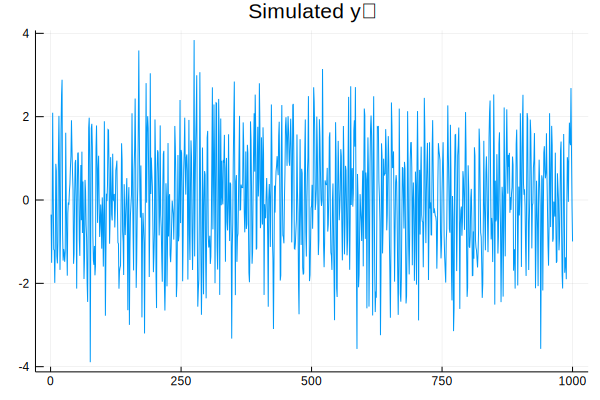

In [2]:
using Polynomials, Plots, LinearAlgebra, Statistics, Random
Random.seed!(747697)
T = 1000
R = 50
θ = 0.1
r = 0.99

# We start with an AR(P). We specify coefficients by choosing the
# roots of the AR polynomial.  In a linear model, complex roots on the
# unit circle lead to non-vanishing cycles in y. 
roots = [r*exp(im*θ),   r*exp(-im*θ), 0.5]

p = prod([Poly([1, -r]) for r in roots])
α = -real(coeffs(p))[2:end]
function mean_y_fn(α, transform=(x)->x)
  ylag->transform(dot(ylag, α))
end
function dgp(mean_y, T, sig=1, yinit=zeros(length(α)))
  ylag = yinit
  y = zeros(T)
  for t in 1:T
    y[t] = muladd(sig, randn(),mean_y(ylag) )
    ylag[2:end] .= ylag[1:(end-1)]
    ylag[1] = y[t]
  end
  return(y)
end

μy = mean_y_fn(α, x->1/r*tanh(x))
y = dgp(μy, T, 1.0)
plot(y, title="Simulated yₜ", leg=false)

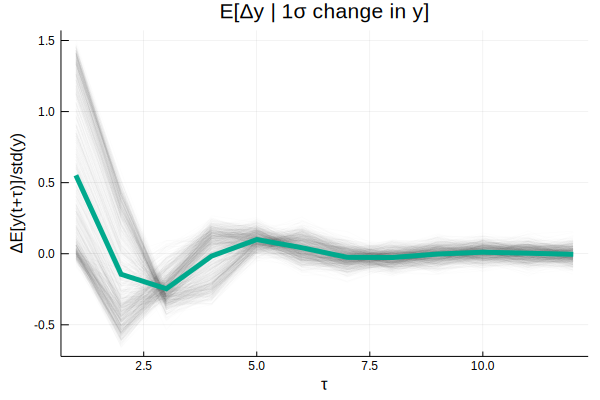

In [3]:
R = 12
L = length(α)
Δ = 1.0*std(y)
nsim = 1000
iry=reduce(hcat,[mean(x->(dgp(μy , R, 1.0, y[i:(i+L-1)] .+ [Δ, 0, 0]) .-
                          dgp(μy , R, 1.0, y[i:(i+L-1)]) ),  1:nsim)
                 for i in 1:(T-length(α)+1)])./std(y)
plot(iry, leg=false, alpha=0.01, color=:black, linewidth=1)
plot!(mean(iry, dims=2), leg=false, linewidth=5, title="E[Δy | 1σ change in y]",
      xlab="τ", ylab="ΔE[y(t+τ)]/std(y)", alpha=1)

The conditional average impulse responses at each $x_t=(y_{t-1}, ..., y_{t-p})$ in the
simulated data are in grey. The average over $x_t$ is the thicker
green-ish line. In a linear model the average and
conditional impulse responses coincide. In this model, they differ
because of the nonlinearity. 

## Estimators

To somewhat simplify this exercise, we will assume that the researcher
knows that $y$ follows a nonlinear AR(3) model. That is, we know that
$$
y_t = h(y_{t-1}, y_{t-2}, y_{t-3}) + \epsilon_t
$$
We will estimate $h$ using this knowledge. To estimate the impulse
response, we need estimates of the conditional expectation of $y$ and
the density of 
$x_t = (y_{t-1}, y_{t-2}, y_{t-3})$. 

### Density 

We will estimate the density as the derivative of a feed forward
network. We fit the a feed forward network to the empirical cdf. We
penalize the estimated cdf for not being monotone. Here is code to fit
the model.

In [4]:
using Flux, ProgressMeter, JLD2
import Base.Iterators: partition
L = length(α)
x = copy(reduce(hcat,[y[l:(end-L+l)] for l in L:-1:1])')

function fit_cdf!(model, x;
                  opt=Flux.NADAM(), maxiter=1000, batchsize=length(x),
                  λ = eltype(x)(1.0), n_extra=0)
  # we could augment cdf evaluation points with x not seen in the data
  # in 1-d, there is no need, but in multiple dimension, there's extra info.
  i = 0
  X = x
  if (n_extra>0)
    X=hcat(x, rand(x, size(x,1), n_extra))
  end
  ecdf = eltype(x).(mapslices( xi->mean(all(X .<= xi, dims=1)), X, dims=1 ))
  Δ = gpu(diagm(fill(eltype(x)(0.01), size(x,1))))
  monotone_penalty(x,cdf) = λ*sum(δ->sum( relu.(model(x) .- model(x .+ δ))), eachcol(Δ))
  loss(x,cdf) = Flux.mse(model(x), cdf) + monotone_penalty(x, cdf)
  @show bestloss = loss(X,ecdf)+1
  lastimprove=0
  p = Progress(maxiter, 1)
  data = [(X[:,p], ecdf[:,p]) for p in partition(1:size(X,2), batchsize)]
  for i in 1:maxiter
    Flux.train!(loss, Flux.params(model),
                data, opt)
    obj = Tracker.data(loss(X, ecdf))
    next!(p)
    (i%(maxiter ÷ 10) == 0) && println("\n$i : $obj")
    if (obj < bestloss)
      bestloss=obj
      lastimprove=i
    end
    if (i - lastimprove > 100)
      @warn "no improvement for 100 iterations, stopping"
      break
    end
  end
  return(model)
end

fit_cdf! (generic function with 1 method)

We can recover the pdf from the cdf by differentiating. For univariate
distributions, this is easy. However, for multivariate distributions,
$$
f_x(x) = \frac{\partial^n}{\partial x_1 \partial x_2\cdots \partial
x_n} F_x(x) 
$$
so we need to evaluate an $n$th order derivative. Here is some code to
do so.

In [5]:
using ForwardDiff
function deriv_i(f, i)
  # derivative wrt to ith argument
  dfi(z)=ForwardDiff.derivative((y)->f([z[1:(i-1)]..., y, z[(i+1):end]...]), z[i])
end

function make_pdf(cdf, dim)
  fs = Function[]
  push!(fs, x->cdf(x))
  for i in 1:dim
    push!(fs, deriv_i(fs[end], i))
  end
  function f(x::AbstractVector)
    fs[end](x)
  end
  function f(x::AbstractMatrix)
    mapslices(fs[end], x, dims=1)
  end
  return(f)
end

make_pdf (generic function with 1 method)

To check that the code produces reasonable results, we will begin by
just fitting the marginal distribution of $y_t$. This isn't quite what
we need for our impulse responses, but it is easier to visualize.

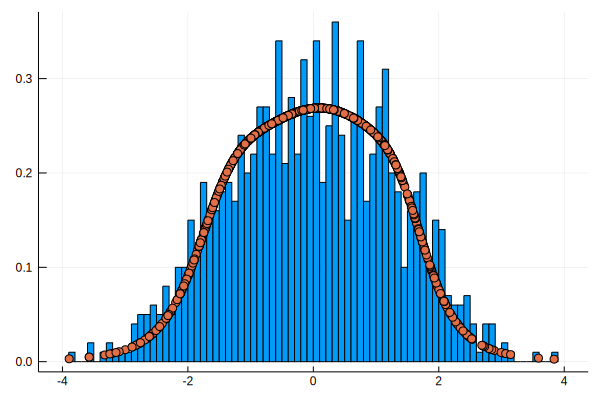

In [6]:
modelfile=joinpath(docdir,"jmd","cdfy.jld2")
rerun=false
if isfile(modelfile) && !rerun  
  @load modelfile cdfy
else
  cdf_model = Chain(
    Dense(1, 8, Flux.σ),
    #Dense(32, 16, relu),
    #Dense(16, 8, relu),
    Dense(8, 1, Flux.σ)
  ) |> gpu
  fit_cdf!(cdf_model, gpu(reshape(y, 1, T)),
           maxiter=10000, batchsize=1000)
  # The next line converts the parameters of the model to Floats instead
  # of Tracked.
  cdfy = cpu(Flux.mapleaves(Flux.data, cdf_model))
  @save modelfile cdfy
end
pdfy = make_pdf(cdfy, 1)

fig=histogram(y, bins=100, normalize=:pdf)
fig=scatter!(y, pdfy(reshape(y,1,T))[:], leg=false)

The estimated pdf looks pretty good. 

We will estimate the joint cdf and pdf similarly.

sum(pdfx(x) .< 0) = 32


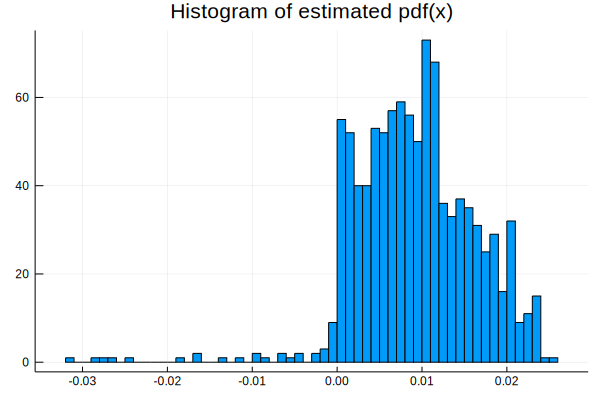

In [7]:
rerun=false
modelfile=joinpath(docdir,"jmd","cdfx.jld2")
if isfile(modelfile) && !rerun  
  @load modelfile cdfx
else
  cdf_model = Chain(
    Dense(3, 32, Flux.σ),
    Dense(32, 16, Flux.σ),
    Dense(16, 8, Flux.σ),
    Dense(8, 1, Flux.σ)
  ) |> gpu
  @time fit_cdf!(cdf_model, gpu(Float32.(x)), opt=NADAM(),
                 maxiter=50000, batchsize=1000, λ=10.0f0, n_extra=10000)
  # The next line converts the parameters of the model to Floats instead
  # of Tracked.
  cdfx = cpu(Flux.mapleaves(Flux.data, cdf_model))
  @save modelfile cdfx
end
pdfx = make_pdf(cdfx, size(x,1))
@show sum(pdfx(x).<0)
histogram(pdfx(x)', bins=100, leg=false, title="Histogram of estimated pdf(x)")

Despite the penalty, our estimated pdf is sometimes
negative. Fortunately, it doesn't happen to often.

It's hard to visualize the estimated trivariate pdf, but we can plot
the marginal pdf implied by the joint distribution. We can get
marginal pdf by integrating or looking at the derivative of the joint cdf.
$$
f_{x_1}(x_1) = \frac{\partial}{\partial x_1} F_x((x_1, \overline{x}_2, \overline{x}_3))
$$
where $\overline{x}_k$ is the maximum of the support of $x_k$.

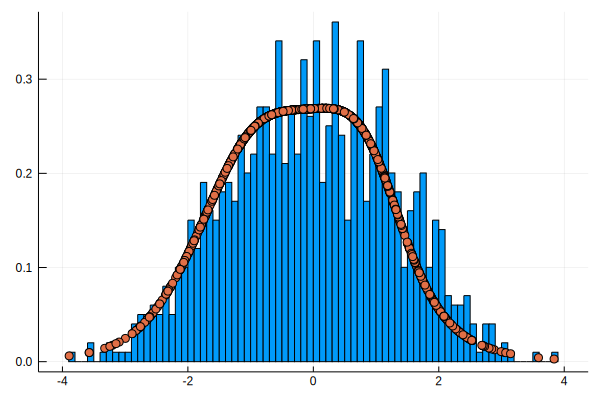

In [8]:
pdf12=make_pdf(cdfx,2)
pdf1=make_pdf(cdfx,1)
px1=pdf1(vcat(x[1,:]', maximum(y)*ones(2, 998)))
histogram(x[1,:], bins=100, normalize=:pdf); scatter!(x[1,:], px1[:], leg=false)

The marginal pdf implied by the joint cdf looks pretty good. 

Note, however, that to get this result, I had to specify a fairly
complex network, which took around 20 minutes to fit. There are many
other ways to estimate densities, and it seems to me that another
approach might have made more sense here. 

### Conditional expectation

We will assume that we that knows that $y$ follows a nonlinear AR(3)
model. Then, we can simply fit a feed forward network to predict $y_t$
given $x_t = (y_{t-1}, y_{t-2}, y_{t-3})$.

In [9]:
function fit_ce!(model, x, y;
                 opt=Flux.NADAM(), maxiter=1000, batchsize=length(y))
  loss(x,y) = Flux.mse(model(x), y)
  @show bestloss = loss(x,y)+1
  lastimprove=0
  p = Progress(maxiter, 1)
  data = [(x[:,p], y[:,p]) for p in partition(1:size(x,2), batchsize)]
  for i in 1:maxiter
    Flux.train!(loss, Flux.params(model),
                data, opt)
    obj = Tracker.data(loss(x,y))
    next!(p)
    (i%(maxiter ÷ 10) == 0) && println("\n$i : $obj")
    if (obj < bestloss)
      bestloss=obj
      lastimprove=i
    end
    if (i - lastimprove > 100)
      @warn "no improvement for 100 iterations, stopping"
      break
    end
  end
  return(model)
end

R = 12 # how many periods ahead to fit
Y = copy(reduce(hcat,[y[(L+r):(end-R+r)] for r in 1:R])')
X = x[:,1:(end-R)]

modelfile=joinpath(docdir,"jmd","ce.jld2")
rerun=false
if !isfile(modelfile) || rerun
  ce_model = Chain(Dense(size(X,1), 8, relu),
                   Dense(8, 8, relu),
                   Dense(8, size(Y,1))) |> gpu
  fit_ce!(ce_model, gpu(Float32.(X)), gpu(Float32.(Y)), opt=Flux.NADAM(),
          maxiter=20000, batchsize=size(Y,2))
  cpum = cpu(ce_model)
  @save modelfile cpum
end
@load modelfile cpum
ce_model = gpu(cpum)

μhat(x) = let m=cpu(Flux.mapleaves(Flux.data, ce_model))
  m(x)
end
μhat(x::AbstractVector) = let m=cpu(Flux.mapleaves(Flux.data, ce_model))
  eltype(x)(m(x)[1])
end

μhat (generic function with 2 methods)

Finally, we can calculate the orthogonalized impulse responses. As
stated above, these are given by
$$
\theta = (h(x+\Delta) - h(x)))  + (y - h(x))\frac{-f_x(x-\Delta)+f_x(x)} {f_x(x)}
$$

Let's compute it

In [10]:
L = size(x,1)
Δ = 1.0*std(y)
iryhat=(μhat(X .+ [Δ; 0; 0])  .- μhat(X))
fx(x) = pdfx(x)  #max.(pdfx(x), 1e-6)
ℓ(x) = (fx(X) .- fx(X .- [Δ; 0; 0]))./fx(X)
lx = ℓ(x)[:]
c = quantile(lx, [0.02, 0.98])
idx = Int.(findall((c[1] .<= lx) .& (lx .<= c[2])))
θi = μhat(X .+ [Δ; 0; 0])  .- μhat(X) .+ (Y .- μhat(X)).*ℓ(X)
#θi = θi[:,idx]

12×986 Array{Float64,2}:
  0.354854    0.567962   0.250375   …   0.998439    0.655263   2.05714  
 -0.059047    0.810314  -0.332311      -1.55374    -0.30901    0.680628 
 -0.293522    0.990159  -0.0644051     -1.24863    -0.41038   -0.258633 
 -0.294809    3.24035    0.0530366      0.0607313   0.218149  -0.323369 
  0.18958     1.83603   -0.18155        1.15136     0.348306   1.41246  
  0.283239   -1.352     -0.168744   …   0.72709     1.54169    1.98714  
  0.0515995  -1.22355    0.242003       1.38192     1.65302    1.29519  
 -0.139741    2.06527    0.314715       1.30407     0.858      0.950252 
 -0.14541     2.8484    -0.0643276      0.500043    1.01717    2.47394  
  0.0127728   1.83956   -0.390266       1.07816     2.73664    1.32428  
  0.395247   -1.88046   -0.108431   …   3.00692     1.40305   -0.0268422
  0.303252   -3.5784     0.276321       1.48213    -0.129472  -1.07888  

and plot it

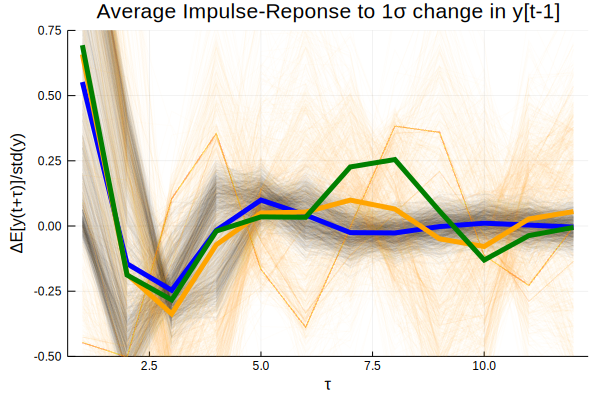

In [11]:
plot(iry, leg=false, alpha=0.02, color=:black, linewidth=1)
plot!(iryhat, leg=false, alpha=0.02, color=:orange, linewidth=1, ylim=(-0.5, 0.75))
#plot!(θi, leg=false, alpha=0.01, color=:green, linewidth=1, ylim=(-0.5, 0.75))
plot!(mean(iry, dims=2), leg=false, linewidth=5, title="Average Impulse-Reponse to 1σ change in y[t-1]",      
     xlab="τ", ylab="ΔE[y(t+τ)]/std(y)", color=:blue)
plot!(mean(iryhat, dims=2), leg=false, linewidth=5, color=:orange)
plot!(mean(θi, dims=2), leg=false, linewidth=5, color=:green)

The true average impulse response is in blue. The uncorrected estimate
is in orange. The orthogonalized estimate is in green. 

Depending on the luck of RNG, and how well I have chosen the network
architectures, the orthogonalized or naive point estimate might look
better. However, the motivation is the orthogonalization is not so
much to improve point estimation (although it does that as a side
effect), but to enable inference.

### Inference

Inference for the orthogonalized estimator is very simple. Due to the
orthogonalization, we can treat `μhat` and `fx` as though they are
known functions. The estimated average impulse response is then just a
sample average. Computing standard errors for sample averages is
straightforward. Since this data is dependent, we will use a HAC
estimator for the variance.

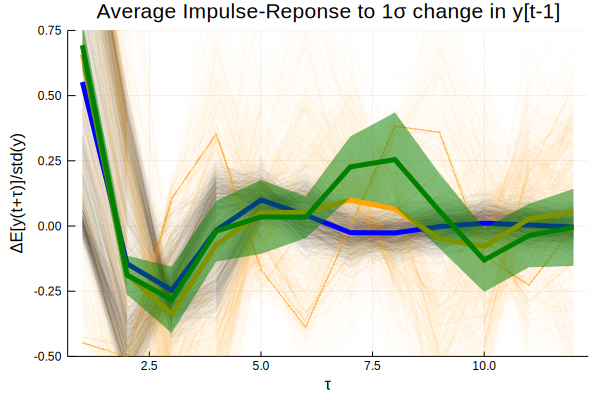

In [12]:
using Distributions
using CovarianceMatrices # I think need dev version for now
k = BartlettKernel{NeweyWest}()
Σ = lrvar(k, θi', prewhite=true)

plot(iry, leg=false, alpha=0.02, color=:black, linewidth=1)
plot!(iryhat, leg=false, alpha=0.02, color=:orange, linewidth=1, ylim=(-0.5, 0.75))
#plot!(θi, leg=false, alpha=0.01, color=:green, linewidth=1, ylim=(-0.5, 0.75))
plot!(mean(iry, dims=2), leg=false, linewidth=5, title="Average Impulse-Reponse to 1σ change in y[t-1]",      
     xlab="τ", ylab="ΔE[y(t+τ)]/std(y)", color=:blue)
plot!(mean(iryhat, dims=2), leg=false, linewidth=5, color=:orange)
plot!(mean(θi, dims=2), leg=false, linewidth=5, color=:green,
      ribbon=sqrt.(diag(Σ)/size(θi,2))*quantile.(Normal(), [0.05, 0.95])' )

The plot now has 90\% pointwise confidence bands around the
orthogonalized estimates. 

# Automating Orthogonalization

A downside of the above approach is it requires an orthogonal moment
conditioon for each parameter of interest. Analytic orthogonalization
is labor intensive, error prone, and may not even be possible in some
cases. @ceinr2016 review some techniques for constructing orthogonal
moments. 


@cnr2018 have a mathematically elegant method for automatically
constructing orthogonal moments. The focus on estimators that are
linear in their nonparametric component. 
$$
\theta_0 = \Er[m(x,\gamma_0(x))]
$$
where $\gamma(x)$ is an estimate of $\Er[y|x]$, $m()$ is a known
function, $m$ is linear in $\gamma$, and $\theta \in \R$. If we focus
on one horizon, our example above falls into this setup. Anyway, since
$m$ is linear, $\gamma \to \Er[m(x,\gamma(x))]$ is a linear
functional. If $\gamma \in V$, a vector space of functions, then by
definition, $\exists \alpha^\ast \in V^\ast$ such that 
$$
\alpha^\ast \gamma = \Er[m(x,\gamma(x))]
$$
for all $\gamma \in V$. Without more structure on $V^\ast$, this is
little more than alternate notation for
$\Er[m(x,\gamma(x))]$. Fortunately in most applications, an
appropriate space for $\Er[y|x]$ is $V=\mathcal{L}^2(P_x)$. In this case,
$V = V^\ast$, and we know that $\alpha^\ast$ is of the form
$$
\alpha^\ast \gamma = \Er[\gamma(x) \alpha^\ast(x)]
$$

In the example from the previous section, $\alpha^\ast$ can be
explicitly calculated. It is
$$
\alpha^\ast(x) = \frac{-f_x(x-\Delta)+f_x(x)} {f_x(x)}.
$$
In the new notation of this section, the orthogonal moment condition
we used in the previous section becomes
$$
\theta = \Er[ m(x, \gamma(x)) + \alpha^\ast(x)(y - \gamma(x))
$$
It is straightforward to verify that this moment condition is
orthogonal for any $m$ that is linear in $\gamma$. 

The above observations can be turned into an estimator by first fixing
an approximing space for $V$, $V_n$ (e.g. the set neural network with a
given architecture). Then estimate $\gamma$ as above
$$
\hat{\gamma} = \argmin_{\gamma \in V_n} \En[ (y-\gamma(x))^2 ].
$$
Estimate $\alpha$ by solving
$$
\hat{\alpha} = \argmin_{\alpha \in V_n} \sup_{\gamma \in V_n} 
\left(\En[m(x,\gamma(x))] - \En[\alpha(x) \gamma(x)] \right)^2
$$
@cnr2018 work with $V_n$ that are linear in parameters, which helps
simplify the estimation of $\alpha$. A practical and efficient method
for estimating $\alpha$ with neural networks would require some
thought.

Finally, plug-in the estimates of $\gamma$ and $\alpha$ and take an
average to compute $\hat{\theta}$.